# Sea ice deformation from the ice floe tracker measurements
This notebook contains steps to downsample the polygon set and carry out the deformation analysis.

## Polygon selection
In the initial submission, we considered all possible triangles formed by sea ice floes within each image, and rejected those with minimum angle less than 20 degrees. It's not clear what the best method would be to use these triangles for the strain rate estimation. This method (with a slightly relaxed minimum angle criterion of 15 degrees) was used by Itkin et al. 2017. Using all possible triangles results in having many estimates of the deformation in the same region, as the triangles overlap. Another option, as done in e.g. Hutchings et al. 2011, is to select non-overlapping triangles within length scales. 
-- I suspect that my code isn't catching all possible polygons in the unique-floes case




We next turn to sea ice deformation. Deformation estimation requires a consideration of averaging area, and thus the relationship to spatial scaling for deformation differs from that of the FSD and the velocity distributions. In addition to possible effects of floe sizes, we consider the length scale defined by the square root of the area of the triangle used in the strain rate calculation. Prior work has shown that the deformation rate has a fractal-like scale dependence such that the deformation rates are linearly related to the spatial scale in log-log space: $\dot \epsilon \sim L^{-\beta}$. This is a power law form, but does not describe a statistical power law distribution.


To fit the paper better, I need to relate the deformation to the floe-scale ice motion
- smaller floes have higher perturbation velocity --> does that correspond to large deformation?
- how much of the deformation is from the large-scale flow field vs the perturbation velocities?
- if the polygon area is similar to the floe size then we'd see more granular flow effects probably.
   - Does the grain size, perhaps the area/total floe area matter?
- To what extent does the day-to-day variation in the number of polygons matter?
  - Current version has tons of overlapping polygons
  - Better to triangulate instead?


Needs for the updated methods
* Test whether I can use the powerlaw function for this analysis too
* Include floe rotation and area in the analysis




# Distribution of deformation within length scale bins
Power law distribution vs lognormal distribution. MLE estimate (Bouchat and Tremblay papers), comparison with Spreen (2017), Rampal (2019).
Clauset et al. and Bouchat and Tremblay -- use of sampling from fitted distribution and getting the p-value of the sample distribution. 

# Estimation of the scaling parameter
Bouchat and Tremblay (2020) considered the effects of uncertainty in the deformation scaling rates. They compiled a table of RGPS and buoy data used for strain rate estimation at 1 hr to 3 day time intervals. Approaches to estimating deformation at lengths scales larger than the observation resolution differ. Some authors have opted for coarse-graining, averaging the deformation estimates into larger shapes, while resampling methods evaluate new deformation estimates from subsampled data. They introduce a method for filtering out low-quality estimates of deformation.

# Effects of heterogeneity
How to determine SIC to use? 

# Granular effects
Equivalent of the Knudsen number for sea ice?

In [2]:
import proplot as pplt
import pandas as pd
import numpy as np
import pyproj
import powerlaw
from shapely.geometry import Point, Polygon

In [103]:
def normal_log_likelihood(eps, L, beta):
    n = len(eps)
    data = np.log(eps*L**beta)
    mu = np.mean(data)
    sigma = np.std(data)
    normalizer = -n/2*np.log(2*np.pi*sigma**2)
    return normalizer - np.sum(data - mu)**2/(2*sigma**2)

In [9]:
# Load and clean trajectories
ift_data = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv')
ift_data['datetime'] = pd.to_datetime(ift_data['datetime'])
init_n = len(ift_data)

# # Require a minimum of at least 1 pixel total displacement
# ift_data = ift_data.groupby('floe_id').filter(lambda x: net_displacement_meters(x) > 500)

# # Max speed has to be less than 1 m/s and greater than 0.05 m/s
# ift_data = ift_data.groupby('floe_id').filter(lambda x: (estimated_max_speed(x) < 1) & \
#             (estimated_max_speed(x) > 0.05))

In [10]:
# Load deformation data
df = pd.read_csv('../data/deformation/sampled_results.csv', index_col=0)
df['datetime'] = pd.to_datetime(df['datetime'])

# Define logarithmically spaced bins
logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['polygon_area'])
df['log_bin'] = np.digitize(df['L'], logbins)

date = pd.to_datetime('2013-04-24 12:00:00')
df_date = df.loc[df.datetime == date]
traj_date = ift_data.loc[ift_data.datetime == date]

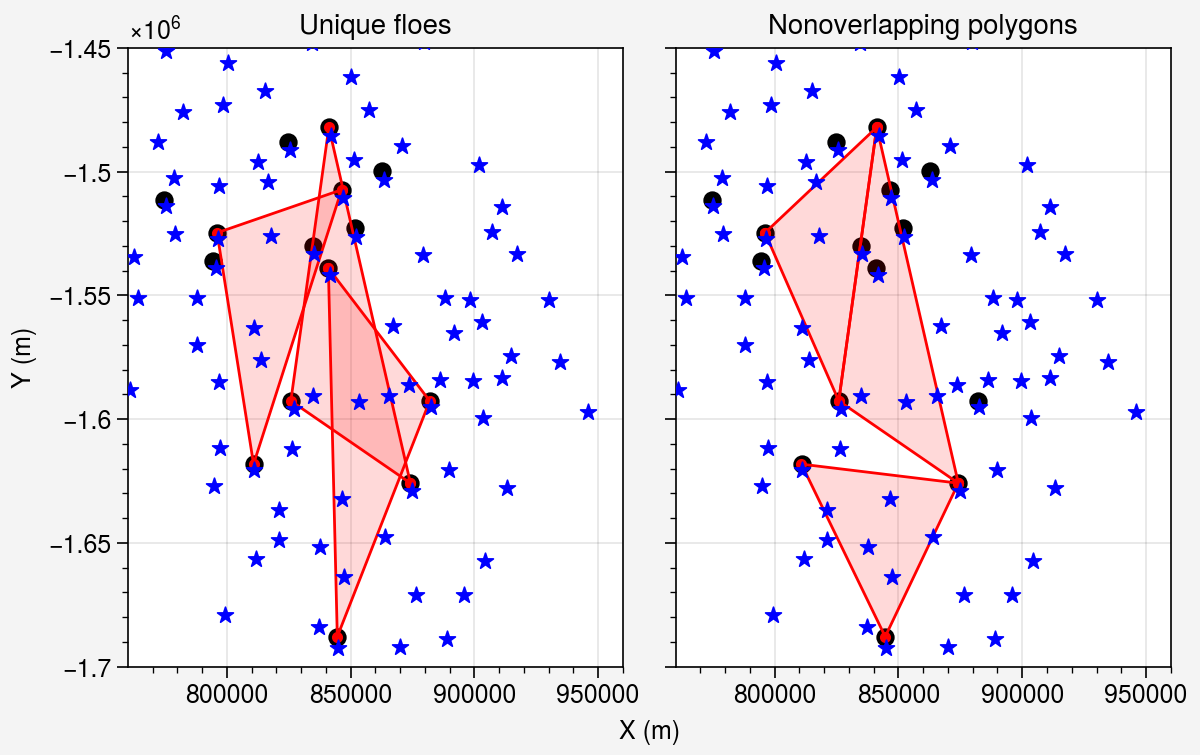

In [82]:


fig, axs = pplt.subplots(width=6, aspect=1, ncols=2)
for ax, sample_type in zip(axs, ['unique_floes_sample', 'no_overlap_sample']):
    for color, lb in zip(['r', None], [5]):
        df_bin = df_date.loc[df_date.log_bin == lb]
        polygons_init = []
     
        samples = []
        for row, data in df_bin.loc[df_bin[sample_type], :].iterrows():
            samples.append(Polygon([Point(x, y) for x, y in zip([data.x1, data.x2, data.x3],
                                                        [data.y1, data.y2, data.y3])]))
        
        ax.scatter(traj_date.x_stere.values, traj_date.y_stere.values, marker='o', color='k')
        ax.scatter(df_full_date.x_stere.values, df_full_date.y_stere.values, marker='*', color='b', zorder=5)
        for p in polygons_init:
            ax.plot(*p.exterior.xy, color='k', lw=0.5, marker='', alpha=0.25)
            ax.plot(*p.exterior.xy, color='k', lw=0, marker='.')
        
        # colors = [c['color'] for c in pplt.Cycle('spectral', 5)]
        
        # for c, p in zip(colors*int(len(samples)/5), samples):
        for p in samples:
            ax.plot(*p.exterior.xy, lw=1, zorder=2, alpha=1, c=color, marker='.')
            ax.fill(*p.exterior.xy, lw=0, zorder=2, alpha=0.15, c=color)
        ax.format(ylim=(-1.7e6, -1.45e6), xlim=(0.76e6, 0.96e6))
    axs[0].format(title='Unique floes', xlabel='X (m)', ylabel = 'Y (m)')
    axs[1].format(title='Nonoverlapping polygons')

# Visualizing the polygons from the deformation analysis. 
- To line up with the original imagery, I need to grab the raw tables.
- Image with nearest date

In [76]:
import pandas as pd
import proplot as pplt

# Load deformation data
df = pd.read_csv('../data/deformation/sampled_results.csv', index_col=0, parse_dates=['datetime'])

df.columns

Index(['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
       'u3', 'v1', 'v2', 'v3', 'x1', 'x2', 'x3', 'y1', 'y2', 'y3', 'area_km21',
       'area_km22', 'area_km23', 'zeta1', 'zeta2', 'zeta3', 'edge_dist_km1',
       'edge_dist_km2', 'edge_dist_km3', 'coast_dist_km1', 'coast_dist_km2',
       'coast_dist_km3', 'polygon_area', 'min_angle', 'L', 'log_bin',
       'no_overlap_sample', 'unique_floes_sample'],
      dtype='object')

In [78]:
# Helper function for deformation
def mean_accel(xcomp, ucomp, area, sign):
    """xcomp and ucomp input should be an N x 3 array. Different gradients will need
    different combinations of x, y, u, and v. In particular:
        dudx = accel(Y, U, A, 1)
        dudy = accel(X, U, A, -1)
        dvdx = accel(Y, V, A, 1)
        dvdy = accel(X, V, A, -1)
    xcomp should be in polar stereographic components.    
    """
    nr, nc = xcomp.shape
    total = np.zeros(nr)
    for idx in range(nc):
        idx1 = (idx + 1) % nc
        total += (ucomp[:, idx1] + ucomp[:, idx])*(xcomp[:, idx1] - xcomp[:, idx])
    return 1/(2*area) * total * sign

df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# calculate deformation
xcoords = np.array([df['x1'], df['x2'], df['x3']]).T
ycoords = np.array([df['y1'], df['y2'], df['y3']]).T
ucoords = np.array([df['u1'], df['u2'], df['u3']]).T
vcoords = np.array([df['v1'], df['v2'], df['v3']]).T

area = df['polygon_area'].values*1e6 # convert back to meters. 

dudx = mean_accel(ycoords, ucoords, area, 1)
dudy = mean_accel(xcoords, ucoords, area, -1)
dvdx = mean_accel(ycoords, vcoords, area, 1)
dvdy = mean_accel(xcoords, vcoords, area, -1)

df['divergence'] = dudx + dvdy #div = epsilon_i
df['vorticity'] = dvdx - dudy #vor
df['pure_shear'] = dudy + dvdx #pure
df['normal_shear'] = dudx - dvdy #normal
df['total_deformation'] = 0.5*np.sqrt((dudx - dvdy)**2 + (dudy + dvdx)**2) #epsilon_ii = total deformation


In [93]:
# separation distance
df['d12'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
df['d13'] = np.sqrt((df['x1'] - df['x3'])**2 + (df['y1'] - df['y3'])**2)
df['d23'] = np.sqrt((df['x3'] - df['x2'])**2 + (df['y3'] - df['y2'])**2)

# area fraction = total floe area divided by polygon area
df['area_fraction'] = (df['area_km21'] + df['area_km22'] + df['area_km23']) / df['polygon_area']

# mean separation dist
# separation distance accounting for floe size
d12 = np.max([np.zeros(len(df)), df['d12'] - np.sqrt(df['area_km21']) - np.sqrt(df['area_km22'])], axis=0)
d13 = np.max([np.zeros(len(df)), df['d13'] - np.sqrt(df['area_km21']) - np.sqrt(df['area_km23'])], axis=0)
d23 = np.max([np.zeros(len(df)), df['d23'] - np.sqrt(df['area_km22']) - np.sqrt(df['area_km23'])], axis=0)

df['mean_separation'] = 1/3*(d12 + d13 + d23)
df['mean_separation_ratio'] = df['mean_separation']/df['L']

Analysis procedure. For each image date, I randomly shuffled the dataset, then iteratively select polygons such that each identified ice floe is only used in one polygon per bin. The minimum and maximum bins are excluded from the analysis since they have relatively few observations and cannot be guaranteed to sample the full bin range.
- min number of obs per bin?
- resampling with different initial sets?
- is the result dependent on the minimum angle? (re-run with it set to 30 degrees)
  
We want to understand the following questions
- Do we observe a similar length scale depends with these MIZ observations as we do with previous studies?
- Does the length scale relationship vary through the summer?
- Within a given range, is (a) the lognormal MLE a consistent method to estimate the scale parameter, and (b) does the lognormal distribution describe the variability within length scale bins?
- Does the 

Emphasize that we are not testing whether deformation distributions follow a power law, we are looking at whether the deformation has a power law dependence on the length scale. We are not expecting the counts to follow any particular distribution, this is not a probability distribution function.

Goodness of fit: qq plots by bin size for each month
- question of what is happening in the tails



In [98]:
import powerlaw

$$\sigma_A^2 = \frac{\sigma_X^2}{4}(a^2 + b^2 + c^2)$$
For a right triangle with area 10 km and minimum interior angle 20 degrees, we can calculate that

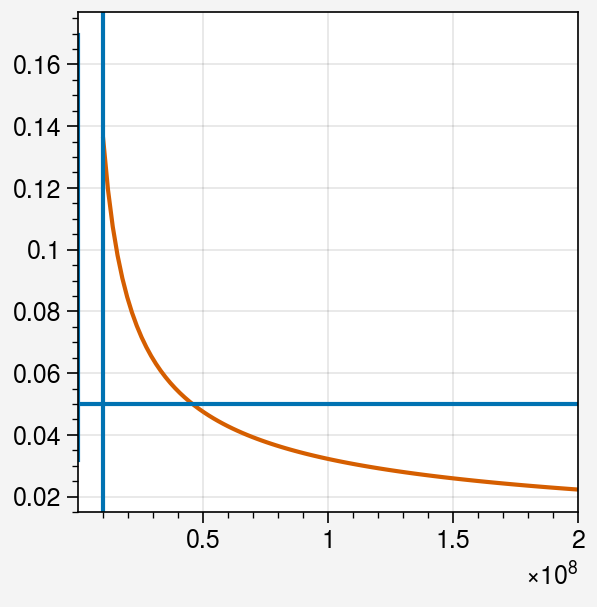

In [64]:
tri_a = np.linspace(10, 200, 100)*1e6
a = np.sqrt(2*tri_a/np.tan(np.deg2rad(10)))
b = a*np.tan(np.deg2rad(20))
c = np.sqrt(h**2 + b**2)
rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/tri_a
fig, ax = pplt.subplots()
a = np.sqrt(2*tri_a/np.tan(np.deg2rad(10)))
b = a*np.tan(np.deg2rad(10))
c = np.sqrt(h**2 + b**2)
rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/tri_a
ax.plot(rel_a)
a = np.sqrt(2*tri_a/np.tan(np.deg2rad(30)))
b = a*np.tan(np.deg2rad(30))
c = np.sqrt(h**2 + b**2)
rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/tri_a
ax.plot(tri_a, rel_a)
ax.axvline(10e6)
ax.axhline(0.05)

We are considering only triangles where the area uncertainty is low

$$\frac{\delta_\epsilon}{\epsilon} = 2\left(4 \frac{\delta_x^2}{A} + 2 \frac{\delta_x^2}{U^2T^2} + \delta_T^2/T^2 + \frac{\delta_A^2}{A^2}\right)^{1/2}$$

In [356]:
def area_uncertainty(data, dx=256):
    a2 = (data.x1 - data.x2)**2 + (data.y1 - data.y2)**2
    b2 = (data.x1 - data.x3)**2 + (data.y1 - data.y3)**2
    c2 = (data.x3 - data.x2)**2 + (data.y3 - data.y2)**2    
    return np.sqrt(dx**2/4*(a2 + b2 + c2))


In [357]:
all_results['polygon_area'].max()

264520.75056

In [358]:
# Add uncertainty calculation here
del_x = 256
T = 24*60*60
del_T = 1*60*60
A = all_results['polygon_area']*1e6
del_A = area_uncertainty(all_results)/A
U = ((all_results['u1']**2 + all_results['v1']**2)**0.5 + \
    (all_results['u2']**2 + all_results['v2']**2)**0.5 + \
    (all_results['u3']**2 + all_results['v3']**2)**0.5)/3
all_results['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                2*del_x**2/(U**2*T**2) + \
                                del_T**2/T**2 + \
                                del_A**2/A**2)


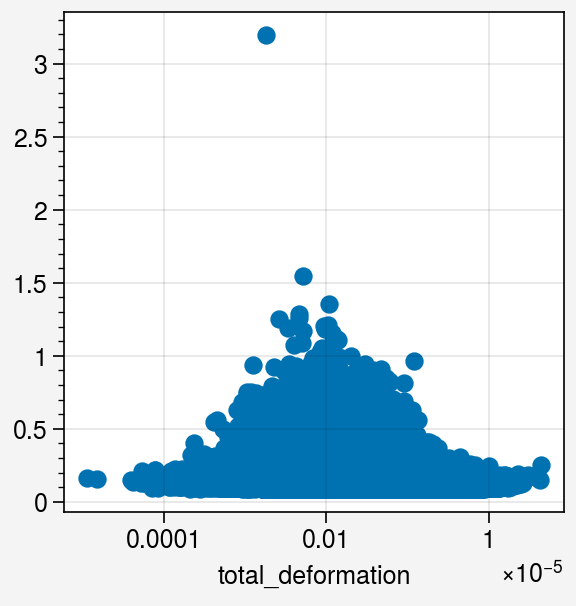

In [362]:
fig, ax = pplt.subplots()
ax.scatter(all_results['total_deformation'], all_results['relative_error'].values, )
ax.format(xscale='log')
# ax.axvline(0.1)

In [270]:
%%time
# Stratified sample by log bin
rs = 32413
n = 500
samples = {4: [], 5: [], 6: []}
for (month, log_bin), group in df.loc[df['no_overlap_sample'], :].groupby(['month', 'log_bin']):         
    if len(group) >= n:
        if month in samples:
            # weight by the number of observations from that date
            w = 1 / group.groupby('datetime').transform(lambda x: len(x))['triangle_number']
            samples[month].append(group.sample(n, replace=False, weights=w, random_state=rs + month + log_bin))
            # weight this by the number of observations per day within each bin
    else:
        pass
        
        # print(month, log_bin, len(group))
for month in samples:
    samples[month] = pd.concat(samples[month])

CPU times: user 2.18 s, sys: 5.64 ms, total: 2.19 s
Wall time: 2.19 s


# Sensitivity of the likelihood results to the sample size
Some questions here: we're using MLE to find the slope. The new sampling method does show some differences, particularly for April. I need to figure out how things vary by length scale, and whether I'm getting the best fit with the lognormal functions. 



(False, False)

In [207]:
%%time
from scipy.stats import linregress
# Build bootstrap analysis of slopes
bs_table = []
for month in samples:
    strat_samp = pd.concat(samples[month], axis=0)
    strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
    mle_results = []
    ls_results = []
    for repeat in range(1000):
        resamp = strat_samp.sample(len(strat_samp), replace=True, random_state=rs + repeat)

        # MLE method - could adjust the function to accept the same data
        likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
        for beta in likelihood_results.index:
            likelihood_results.loc[beta] = normal_log_likelihood(resamp['total_deformation']*(60*60*24),
                                                                 resamp['L'], beta)
        # if the idxmax() is equal to one side or the other, then it didn't find a maximum.
        first = np.abs(likelihood_results.idxmax() - likelihood_results.values[0]) < 1e-5
        last = np.abs(likelihood_results.idxmax() - likelihood_results.values[-10]) < 1e-5
        if not (first | last):
            mle_results.append(likelihood_results.idxmax())
        del likelihood_results

        # Regression method - first tried fitting a line to the means
        # - now trying to fit with the full dataset
        
        # data_mean = resamp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
        # data_std = resamp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
        
        # if len(data_mean) > 5:
        #     beta, a, r, p, err = linregress(np.log(data_mean['L']), np.log(data_mean['total_deformation']*24*60*60))
        beta, a, r, p, err = linregress(np.log(resamp['L']), np.log(resamp['total_deformation']*24*60*60))
        ls_results.append(-beta)
    
    q1_mle, q2_mle = np.quantile(np.array(mle_results), [0.025, 0.975])
    q1_ls, q2_ls = np.quantile(np.array(ls_results), [0.025, 0.975])
    bs_table.append([month, q1_mle, q2_mle, q1_ls, q2_ls])
    
bs_table = pd.DataFrame(bs_table, columns=['month', 'min_beta_mle', 'max_beta_mle', 'min_beta_lsq', 'max_beta_lsq']).set_index('month')
bs_table['beta_mle'] = np.nan
bs_table['beta_lsq'] = np.nan

for month in samples:
    strat_samp = pd.concat(samples[month], axis=0)
    strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                             strat_samp['L'], beta)
    beta = likelihood_results.idxmax()
    bs_table.loc[month, 'beta_mle'] = beta

    # data_mean = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    # data_std = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
    # n = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    if len(data_mean) > 5:
        beta, a, r, p, err = linregress(np.log(strat_samp['L']), np.log(strat_samp['total_deformation']*24*60*60))

        bs_table.loc[month, 'beta_lsq'] = -beta
        bs_table.loc[month, 'a_lsq'] = a


CPU times: user 2min 39s, sys: 148 ms, total: 2min 40s
Wall time: 2min 40s


,min_beta_mle,max_beta_mle,min_beta_lsq,max_beta_lsq,beta_mle,beta_lsq
month,,,,,,
4,0.343317,0.427889,0.343623,0.429104,NaN,NaN
5,0.552261,0.636834,0.551888,0.634495,NaN,NaN
6,0.432740,0.507487,0.430518,0.506108,NaN,NaN


(array([  7.,  21.,  82., 114., 213., 238., 173., 112.,  30.,  10.]),
 array([0.40795078, 0.41975221, 0.43155364, 0.44335507, 0.4551565 ,
        0.46695793, 0.47875936, 0.49056079, 0.50236222, 0.51416365,
        0.52596508]),
 <BarContainer object of 10 artists>)

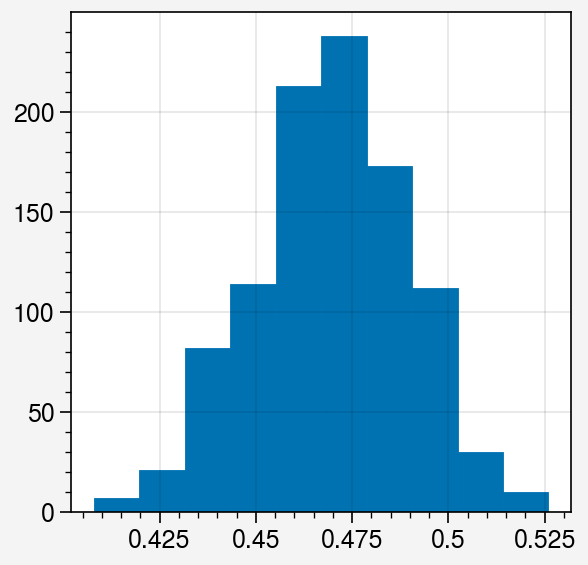

In [272]:
fig, ax = pplt.subplots()
ax.hist(ls_results)

# Standard approach
The typical approach, used by e.g. Hutchings et al. 2024, involves calculating a mean deformation within length scale bins. 

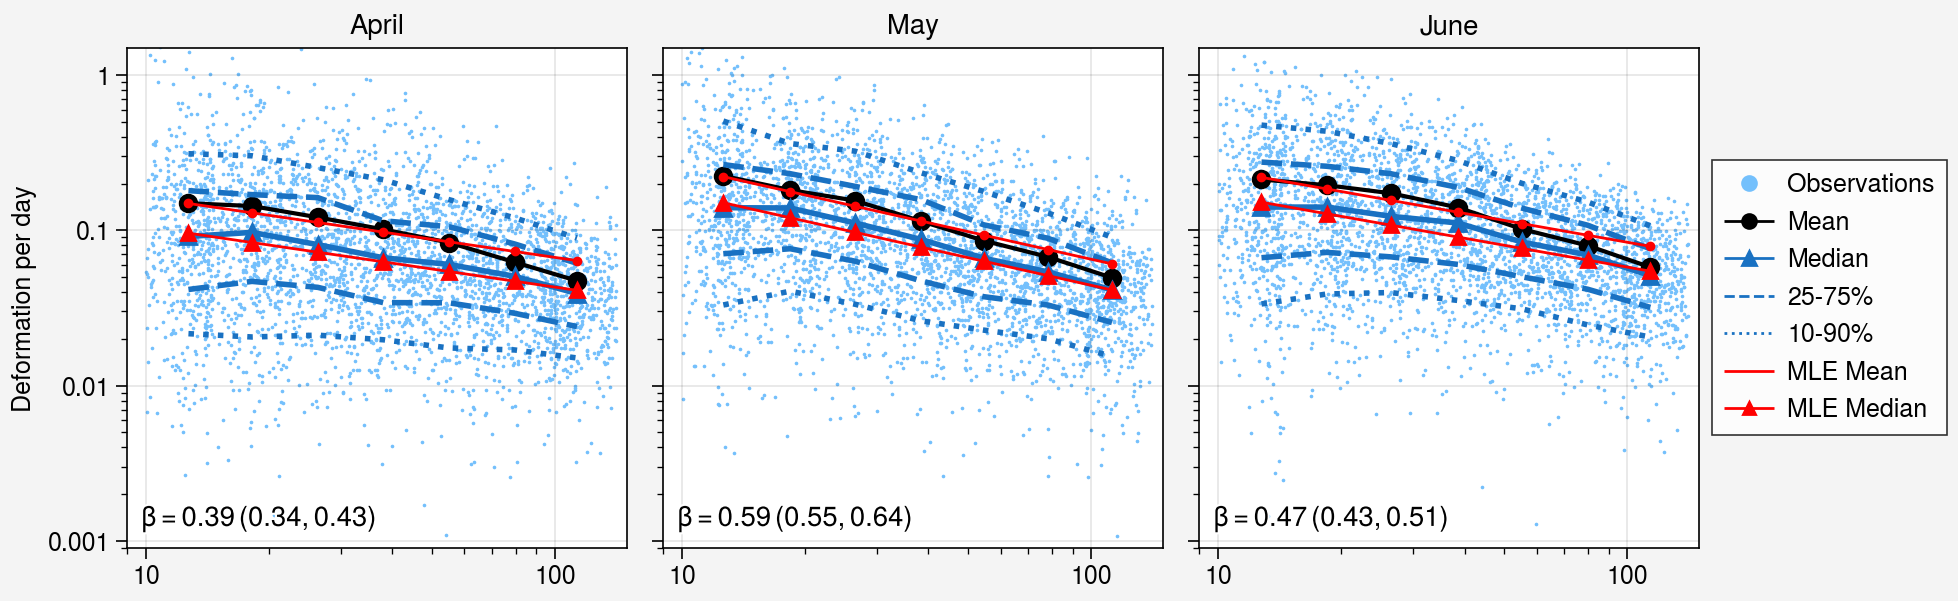

In [268]:
from scipy.stats import linregress
bs_table['reg_est'] = np.nan
fig, axs = pplt.subplots(ncols=3)
for ax, month, monthname in zip(axs, range(4, 7), ['April', 'May', 'June']):
    strat_samp = pd.concat(samples[month], axis=0)
    strat_samp['log_total_deformation'] = np.log(strat_samp['total_deformation'])
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
    data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
    ax.scatter(data['L'].values, data['total_deformation'].values*24*60*60, m='.', color='blue3', ms=2, zorder=0, label='')
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    ax.plot(data_mean['L'].values, data_mean['total_deformation'].values*24*60*60, marker='o', color='k')
    # data_std = data.loc[:, ['L', 'log_total_deformation', 'log_bin']].groupby('log_bin').std()
    
    n = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    # if len(data_mean) > 5:
    #     beta_lsq = bs_table.loc[month, 'beta_lsq']
    #     a_lsq = bs_table.loc[month, 'a_lsq']
        
    #     # ax.errorbar(data_mean['L'].values, np.exp(data_mean['log_total_deformation'].values)*24*60*60, marker='o',
    #     #         yerr=(data_std['log_total_deformation'].values)*24*60*60, 
    #     #             label='', zorder=1, color='tab:blue', lw=1)
        
    #     ax.plot(data_mean['L'].values, np.exp(a_lsq)*data_mean['L'].values**-beta_lsq, label='', marker='^', color='k', zorder=3)

    # bs_table.loc[month, 'reg_est'] = beta
    
    beta_mle = bs_table.loc[month, 'beta_mle']
    scaled_eps = data['total_deformation']*(60*60*24)*data['L']**beta_mle
    mu = np.mean(np.log(scaled_eps))
    sigma = np.std(np.log(scaled_eps))
    mean = np.exp(mu + sigma**2/2)
    ax.plot(data_mean['L'].values, (np.exp(mu)*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='^', ms=5, lw=1, zorder=5)
    ax.plot(data_mean['L'].values, (mean*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='.', ms=5, lw=1, zorder=5)
  
    min_beta = bs_table.loc[month, 'min_beta_mle']
    max_beta = bs_table.loc[month, 'max_beta_mle']    
    mle_result = '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2))
    # get 95% confidence interval using standard error and t distribution
    # # tinv = lambda p, df: abs(t.ppf(p/2, df))
    # # ts = tinv(0.01, len(data_mean) - 2)

    # lr_result = '$\\beta={s:.2f} \, ({lb:.2f}, {ub:.2f})$'.format(s=-beta,
    #                                           lb=-(beta + ts*err),
    #                                           ub=-(beta - ts*err))
    beta_lsq = bs_table.loc[month, 'beta_lsq']
    min_beta = bs_table.loc[month, 'min_beta_lsq']
    max_beta = bs_table.loc[month, 'max_beta_lsq']   
    lr_result = '$\\beta={b:.2f} \, ({minb:.2f}, {maxb:.2f})$'.format(b=np.round(beta_lsq, 2),
                                                                      minb=np.round(min_beta, 2),
                                                                      maxb=np.round(max_beta, 2))
    #                                           lb=-(beta + ts*err),
    #                                           ub=-(beta - ts*err))

    df_quantiles = pd.DataFrame({q: strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
                                 for q in [0.1, 0.25, 0.5, .75, 0.9]},
             index = strat_samp[['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

    for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
        if q == 0.5:
            m = '^'
        else:
            m = ''
        ax.plot(df_quantiles.index, df_quantiles[q].values*24*60*60, color='blue8', ls=ls, lw=2, m=m)
    # ax.format(lltitle='MLE: ' + mle_result + '\n' + 'LSQ: ' + lr_result, xreverse=False)
    ax.format(lltitle=mle_result)
    ax.format(yscale='log', xscale='log', ylim=(0.9e-3, 1.5), ylabel='Deformation per day', xlim=(9, 150), title=monthname, xreverse=False)

h = [ax.plot([],[], c=c, lw=lw, m=m, ms=ms, ls=ls) for c, lw, m, ms, ls in zip(
                ['blue3', 'k', 'blue8', 'blue8', 'blue8', 'r', 'r'],
                [0, 1, 1, 1, 1, 1, 1],
                ['o', 'o', '^', '', '', '.', '^'],
                [5, 5, 5, 0, 0, 0, 4, 5],
                ['', '-', '-', '--', ':', '-', '-'])]
 

# make custom legend
ax.legend(h, ['Observations', 'Mean', 'Median', '25-75%', '10-90%', 'MLE Mean', 'MLE Median'], ncols=1,loc='r')
fig.save('../figures/fig10_deformation_scales.png', dpi=300)

<AxesSubplot:xlabel='log_bin'>

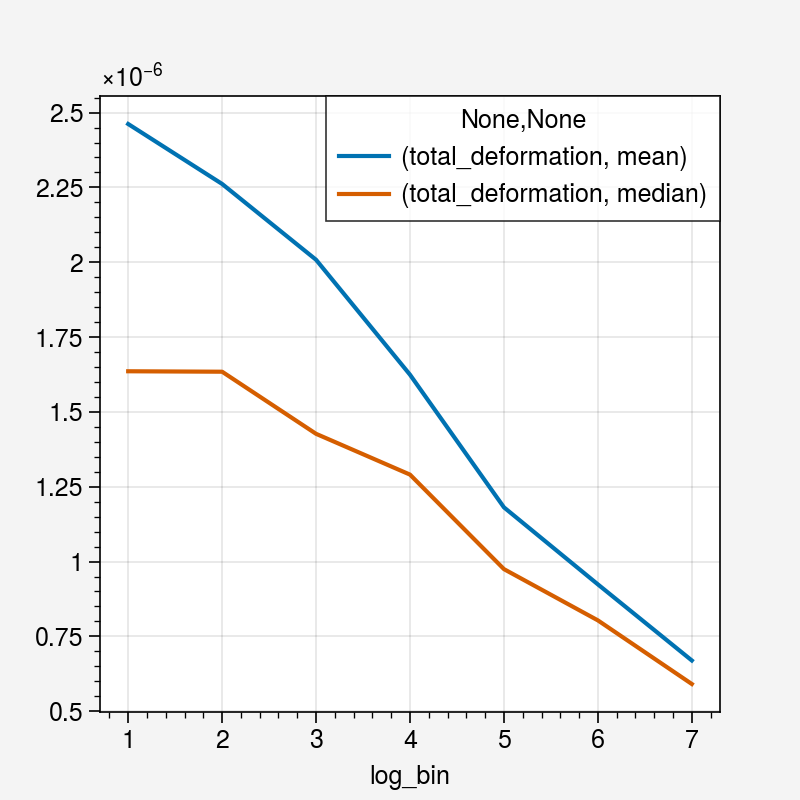

In [234]:
mu = np.mean(np.log(scaled_eps))
sigma = np.std(np.log(scaled_eps))
mean = np.exp(mu + sigma**2/2)
mu, sigma, mean

(-0.6942819031052921, 0.8582204384766647, 0.7217974334120242)

In [244]:
np.exp(a_lsq), np.exp(mu), mean

(0.5022114612962548, 0.49943296050441954, 0.7217974334120242)

Assuming that
$$ y \propto mL^{-\beta}$$
For the LSQ method, we fit a line to the log-transformed data:
$$\log y = \log m - \beta \log L$$
The resulting parameters give us the slope $\beta$ and a y-intercept $A = \log m$ in log space. To transform back into data space, we simply take the exponent of each side, so the estimated value for $m$ is $\exp(A)$.


The line for the MLE method is given by the function
$$ y = mL^{-\beta} $$
where $m = \exp(\mu + \sigma^2/2)$ is the mean of the fitted lognormal distribution with parameters $\mu$, $\sigma$.

TBD:
- Sensitivity of the MLE estimate to outliers
- Sensitivity to sample size
- Uncertainty in the LS mean (add to plot)





(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1.00000023, 1.00000276, 1.0000053 , 1.00000783, 1.00001036,
        1.00001289, 1.00001543, 1.00001796, 1.00002049, 1.00002303]),
 <BarContainer object of 9 artists>)

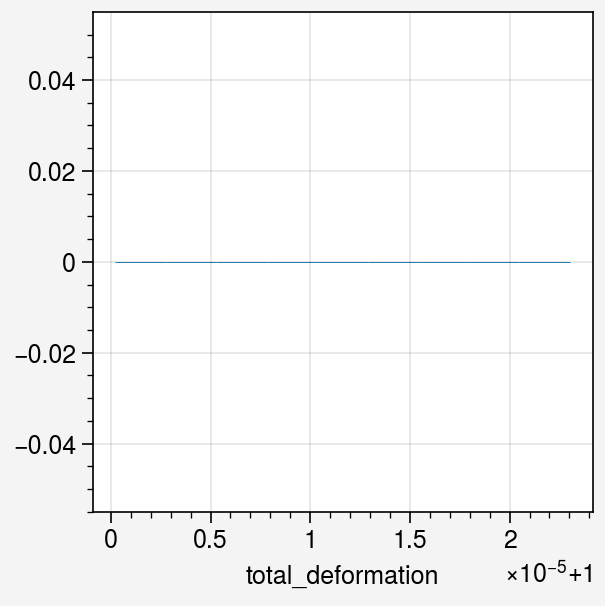

In [227]:
fig, ax = pplt.subplots()
ax.hist(strat_samp.loc[strat_samp.log_bin == 5, 'total_deformation'], bins=np.logspace(0.1e-6, 1e-5, 10))
# ax.format(xscale='log')


In [229]:
np.logspace(0.1e-6, 1e-5, 10)

array([2.71828245, 2.71828934, 2.71829622, 2.71830311, 2.71830999,
       2.71831688, 2.71832376, 2.71833065, 2.71833754, 2.71834442])

In [442]:
import statsmodels.api as sm
np.exp(np.mean(data['total_deformation']*data['L']**beta_mle))

1.000005986501369

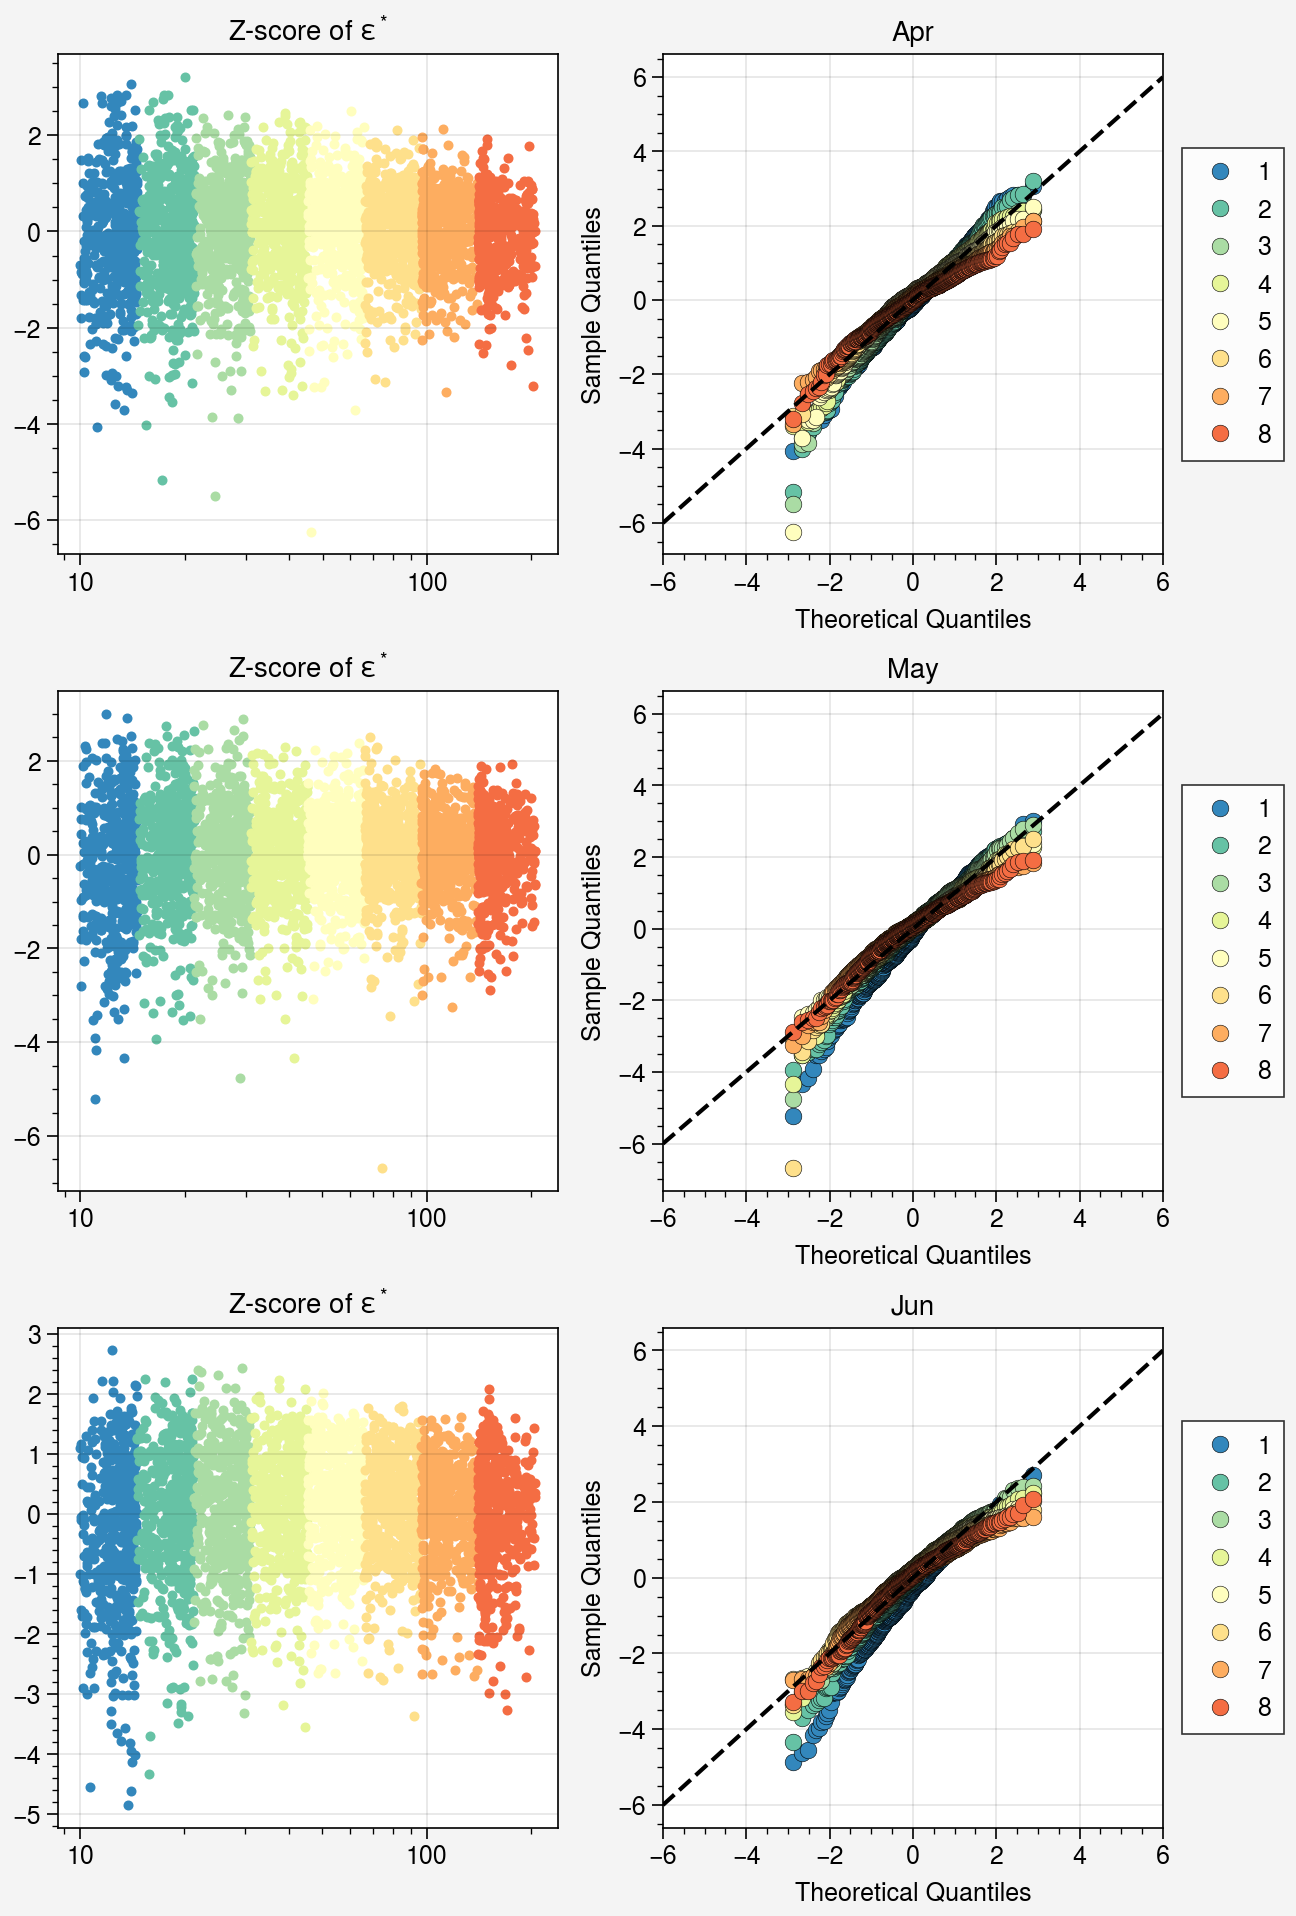

In [479]:
bincolors = {lb: color['color'] for lb, color in zip(np.arange(0, 11),
                                                pplt.Cycle('spectral_r',11))}
fig, axs = pplt.subplots(ncols=2, nrows=3, share=False)
for row, month, monthname in zip([0, 1, 2], [4, 5, 6], ['Apr', 'May', 'Jun']):
    beta_mle = bs_table.loc[month, 'beta']
    strat_samp = pd.concat(samples[month])
    data = np.log(strat_samp['total_deformation']*strat_samp['L']**beta_mle)
    data = pd.DataFrame({'Z': (data - np.mean(data))/np.std(data), 'L': strat_samp['L'], 'log_bin': strat_samp['log_bin']})
    
    axs[row, 0].format(xscale='log', title='Z-score of $\epsilon^*$')
    
    for lbin, group in data.groupby('log_bin'):
        axs[row, 0].scatter(group['L'].values, group['Z'].values, color=bincolors[lbin], marker='.')
        sm.qqplot(group['Z'], ax=axs[row, 1], **{'marker': 'o', 'markerfacecolor': bincolors[lbin], 'markeredgecolor':'k', 'markeredgewidth': 0.2, 'label': lbin})
    axs[row, 1].plot([-6, 6], [-6, 6], color='k', ls='--')
    axs[row, 1].format(title=monthname)
        # ax.hist(group['Z'], bins=np.linspace(-5, 5, 31),
        #         density=True, label='Bin {lb}: {km} km'.format(lb=lbin, km=np.round(np.mean(group['L']), 1)), histtype='step')
    axs[row, 1].legend(ncols=1, loc='r')
    

Some notes based on plotting single groups at a time:
* Small scales seem identically distributed (log bins 1 and 2). Both have a tilted qq plot showing relatively more frequent low values and less frequent high values.
* Next, 3 and 4 are closer to the lognormal distribution for the higher values, but still have relatively more frequent low Z scores
* 5-7 have more frequent high values and less frequent low values, the qq plot is skewed the opposite way
* 

0 0.08
1 0.11
2 0.01
3 0.92
4 0.65
5 0.56
6 1.06
7 0.89
8 0.59
9 0.83
10 0.52
11 1.4


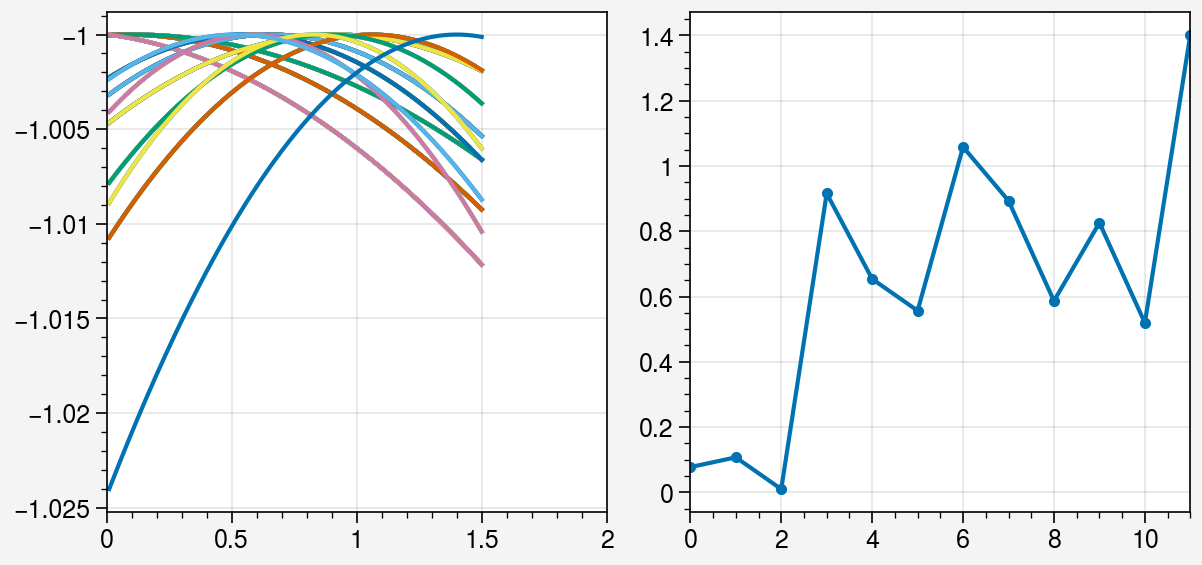

In [79]:
fig, axs = pplt.subplots(ncols=2, share=False)
likelihood_results = pd.DataFrame(np.nan, index=np.linspace(0.01, 1.5, 200), columns=np.arange(0, 11))
for binnum, data in all_results.groupby('log_bin'):
    if len(data) > 1000:
        d = data['total_deformation'].sample(1000)
        for beta in likelihood_results.index:
            likelihood_results.loc[beta, binnum] = normal_log_likelihood(d*(60*60*24),
                                                                 data['L'], beta)
        axs[0].plot(likelihood_results/np.abs(likelihood_results.max()))
        print(binnum, np.round(likelihood_results[binnum].idxmax(),2))
axs[1].plot(likelihood_results.idxmax(axis=0), marker='.')
axs[0].format(xlim=(0, 2))

# TBD
* Compare the local fit to the global fit with alternative methods of fitting a lognormal distribution. Can we rule it out? Are we getting the best mu/std estimates?

Powerlaw distribution application to the data within a length scale bin

In [95]:
import powerlaw
data = pd.concat(samples[5])

In [ ]:
fig, ax = pplt.subplots(width=4)
for log_bin in range(1, 9):
    fit = powerlaw.Fit(np.abs(data.loc[data.log_bin == log_bin, 'divergence']))
    fit.plot_ccdf(ax=ax, color='k')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')

Calculating best minimal value for power law fit
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


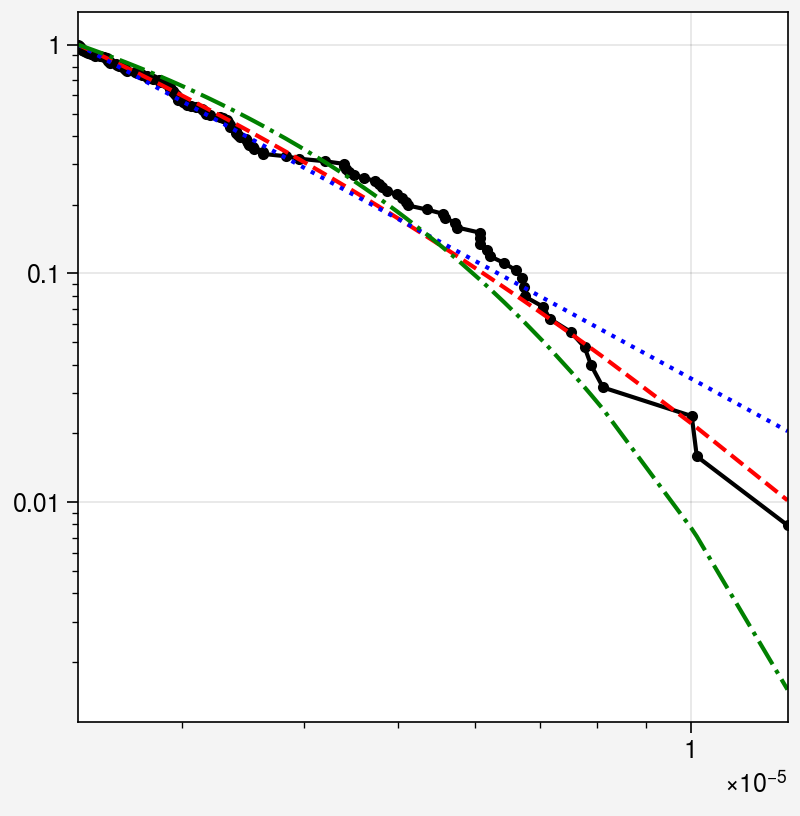

In [108]:
fig, ax = pplt.subplots(width=4)
log_bin = 3
for year in range(2003, 2004):
    d = data.loc[(data.log_bin == log_bin), 'total_deformation']
    fit = powerlaw.Fit(np.abs(d))
    fit.plot_ccdf(ax=ax, color='k', marker='.')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')
    fit.exponential.plot_ccdf(ax=ax, ls='-.', color='g')
# fit.exponential.plot_ccdf(ax=ax)

In [105]:
print(fit.distribution_compare('power_law', 'truncated_power_law', nested=True))
print(fit.distribution_compare('power_law', 'lognormal', nested=True))
print(fit.distribution_compare('power_law', 'exponential', nested=True))
print(fit.distribution_compare('lognormal', 'exponential', nested=True))
print(fit.distribution_compare('lognormal', 'truncated_power_law', nested=True))

(-1.6104207038728378, 0.07270624867493292)
(-1.105953826468446, 0.1369492305833674)
(1.266354447109813, 0.11150863677036904)
(2.372308273578259, 0.029390102836980625)
(-0.5044668774043917, 0.31515841391077304)


Assuming nested distributions
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


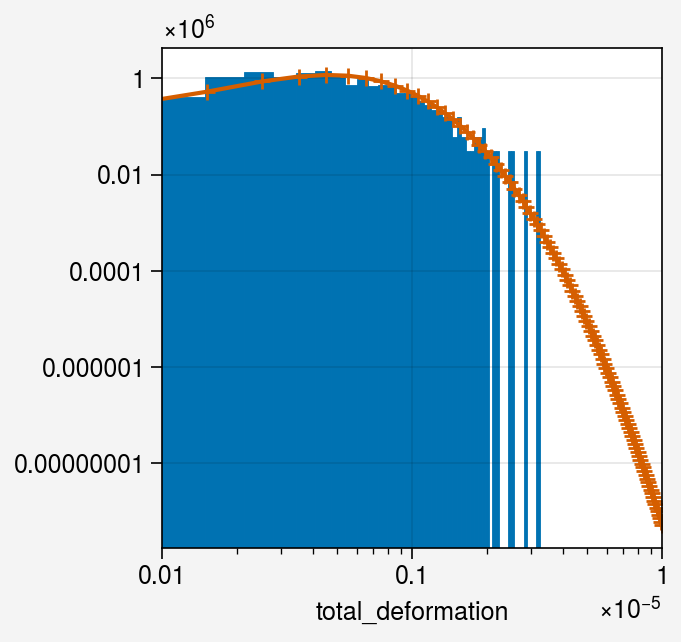

In [141]:
import scipy.stats as stats
fig, ax = pplt.subplots()
log_bin = 7
x = np.abs(data.loc[data.log_bin == log_bin, 'total_deformation'])
ax.hist(x, bins=50, density=True)
shape, location, scale = stats.lognorm.fit(x)
ax.plot(np.linspace(0.5e-7, 1e-5, 100), stats.lognorm.pdf(np.linspace(1e-8, 1e-5, 100), shape, location, scale), marker='+')
ax.format(yscale='log', xscale='log', xlim=(1e-7, 1e-5))

In [519]:
fit.lognormal.mu, fit.lognormal.sigma

(-15.567266079668826, 0.997892889227757)

-2.895422811760541e-07

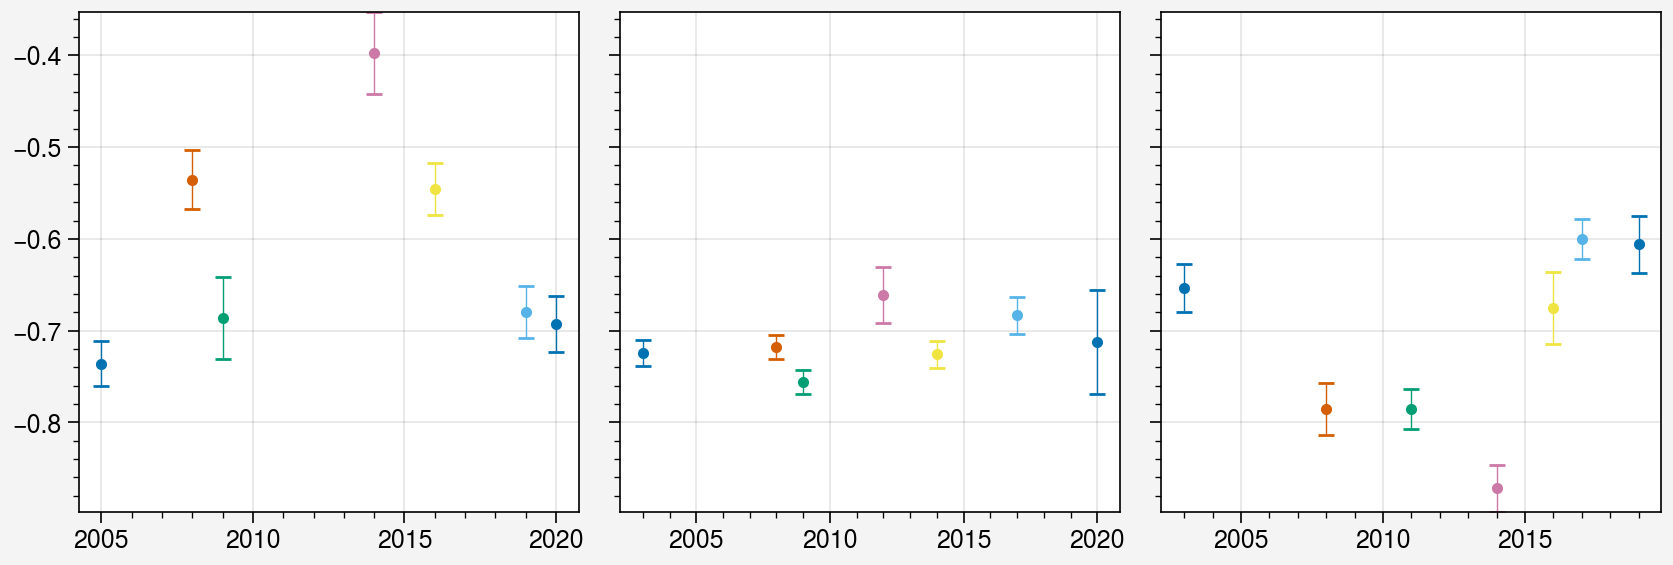

In [188]:
fig, axs = pplt.subplots(ncols=3)
for ax, month in zip(axs, range(4, 7)):
    for year in range(2003, 2021):
        data = all_results.loc[(all_results.datetime.dt.month == month) & (all_results.sampled)]
        data = data.loc[(data.datetime.dt.year == year)]
        data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
        
        data_mean = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
        data_std = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
        n = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
        data_mean = data_mean.where(n['total_deformation'] > 50).dropna()
        data_std = data_std.where(n['total_deformation'] > 50).dropna()
        if len(data_mean) > 6:
            beta, a, r, p, err = linregress(np.log10(data_mean['L']), np.log10(data_mean['total_deformation']*24*60*60))
            
            ax.errorbar([year], [beta], lw=0.5, yerr=[err], marker='.')

In [190]:
strat_samp

,datetime,triangle_number,floe1,floe2,floe3,u1,u2,u3,v1,v2,...,y2,x3,y3,divergence,vorticity,pure_shear,normal_shear,total_deformation,month,year
2303593,2017-06-27 12:00:00,100,2017_06605,2017_06706,2017_06733,-0.06240,-0.02376,-0.03128,-0.12313,-0.06000,...,-1.243667e+06,800228.990369,-1.233436e+06,1.575616e-08,-7.786873e-06,-9.571678e-06,1.351285e-07,4.786316e-06,6,2017
547517,2004-06-06 12:00:00,145,2004_00866,2004_00917,2004_00871,-0.03536,0.01340,0.01526,0.05819,0.04256,...,-1.340278e+06,746372.657482,-1.283294e+06,7.226381e-07,-6.423151e-06,-5.815069e-06,6.353551e-06,4.306467e-06,6,2004
542489,2003-06-24 12:00:00,42,2003_06749,2003_07653,2003_07616,0.06358,0.00745,0.00706,-0.00163,0.02466,...,-1.071340e+06,628648.973907,-1.102096e+06,3.162246e-06,-1.809615e-06,-1.476308e-06,2.666603e-06,1.523996e-06,6,2003
1124256,2011-06-18 12:00:00,997,2011_01767,2011_02176,2011_01960,-0.04058,-0.10172,-0.00280,-0.12094,-0.04234,...,-1.170586e+06,811361.642999,-1.141728e+06,-2.394742e-06,-2.007667e-07,5.726732e-06,-1.710362e-06,2.988344e-06,6,2011
541978,2003-06-22 12:00:00,249,2003_07110,2003_07636,2003_07497,0.06898,0.05047,0.04365,0.09849,0.06193,...,-1.053084e+06,799213.953758,-1.091175e+06,1.270399e-06,1.275129e-06,2.422696e-06,1.255816e-07,1.212974e-06,6,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578283,2014-06-12 12:00:00,11138,2014_05841,2014_06058,2014_06123,0.00729,-0.04126,0.19339,-0.01203,-0.22351,...,-1.407251e+06,851885.810955,-1.060820e+06,1.442573e-06,-1.702346e-06,-7.513553e-07,7.152059e-07,5.186652e-07,6,2014
2637846,2019-06-14 12:00:00,8175,2019_04314,2019_04715,2019_05029,0.00437,-0.02720,-0.04884,-0.12465,-0.07141,...,-1.029972e+06,865034.034307,-7.423103e+05,9.283271e-08,1.485180e-06,1.354768e-06,-8.380519e-07,7.965122e-07,6,2019
1118480,2011-06-17 12:00:00,185,2011_01710,2011_01751,2011_02068,-0.06165,-0.06996,-0.02118,-0.03260,-0.07277,...,-1.043212e+06,719132.743611,-1.310161e+06,-4.863743e-07,-2.089590e-07,-2.928452e-07,-2.621101e-07,1.965070e-07,6,2011
1138043,2011-06-24 12:00:00,3165,2011_02529,2011_02589,2011_02612,0.13012,0.08335,-0.05788,-0.12784,0.04756,...,-1.237000e+06,800729.016800,-9.981294e+05,-2.206344e-06,3.589641e-07,3.881320e-07,-1.498049e-06,7.737567e-07,6,2011


In [16]:
df_100km.columns

Index(['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
       'u3', 'v1', 'v2', 'v3', 'lat1', 'lat2', 'lat3', 'lon1', 'lon2', 'lon3',
       'area', 'min_angle', 'L', 'log_bin', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3',
       'divergence', 'vorticity', 'pure_shear', 'normal_shear',
       'total_deformation', 'month', 'year'],
      dtype='object')

In [19]:
df_ift = pd.read_csv('../data/floe_tracker/ift_with_era5.csv')

In [21]:
# Silly mistake - each floe has multiple distances.
# Need to index both by date and by floe.
# edge_dist = df_ift.loc[:, ['floe_id', 'edge_dist']].set_index('floe_id')


In [ ]:
import pandas as pd
df = pd.read_csv('../data/deformation/ift_deformation_calculations_2003.csv')

In [40]:
df = df.dropna(subset='divergence')

logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['area_km2'])
df['log_bin'] = np.digitize(df['L'], logbins)


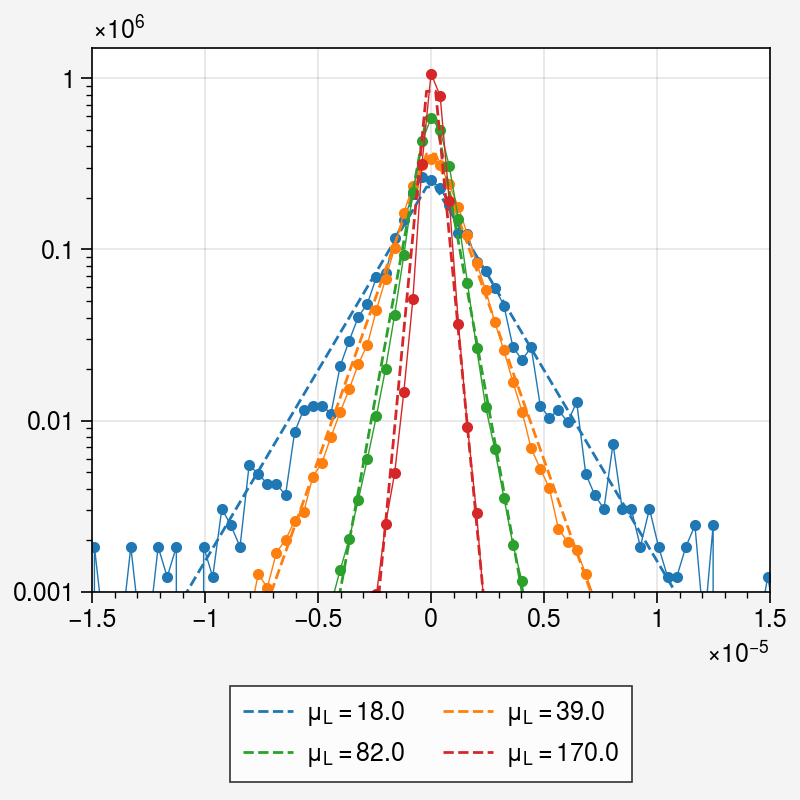

In [78]:
import scipy.stats as stats
var = 'divergence'
colors = pplt.Cycle('tab10', 8)
fig, ax = pplt.subplots(width=4, height=4)
for log_bin, c in zip(range(2, 10, 2), [x['color'] for x in colors]):
    ls = '--'
    if len(df.loc[df.log_bin==log_bin].dropna(subset=var)) > 500:
        
        train = df.loc[df.log_bin==log_bin].dropna(subset=var).sample(500, replace=False)
        # train[[var]] = train[[var]] / train[['length_bin', var]].groupby('length_bin').transform(lambda x: x.std())
        test =  df.loc[df.log_bin==log_bin].dropna(subset=var)
        test = test.loc[[x for x in test.index if x not in train.index], :]
        loc, scale = stats.expon.fit(np.abs(train[var]), floc=0)

        pdf, x_bins = np.histogram(test[var], bins=np.linspace(-3e-5, 3e-5, 150), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        
        ax.plot(x_center, pdf, color=c, label='', marker='.', lw=0.5)
        
        x = np.linspace(-2e-5, 2e-5, 100)
        ax.plot(x, 0.5*stats.expon(loc=loc, scale=scale).pdf(np.abs(x)), ls=ls, c=c, lw=1,
                label='$\mu_L =$' + str(np.round(test['L'].mean())))
        ax.format(yscale='log', ylim=(1e3, 1.5e6), xlim=(-1.5e-5, 1.5e-5))
ax.legend(loc='b', ncols=2)

colors = pplt.Cycle('tab10', 10)
